# Início
Iremos usar um modelo de série temporal para manipulação de dados e predição.

In [1]:
import pandas as pd
import os
import pickle
import numpy as np
from datetime import datetime

# Somente se for utilizado
import yfinance as yf

import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

## Funções

In [2]:
def encontra_melhor_param(data, max_p=5, max_d=2, max_q=5):
    best_aic = np.inf
    best_params = None

    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                try:
                    model = ARIMA(data, order=(p, d, q))
                    fitted = model.fit()
                    if fitted.aic < best_aic:
                        best_aic = fitted.aic
                        best_params = (p, d, q)
                except:
                    continue
    
    print(f"Melhores parâmetros: ARIMA{best_params} com AIC = {best_aic:.2f}")
    return best_params

def gerar_multiplo_forecast(model, steps=30, n_simulations=100):
    forecasts = []

    for i in range(n_simulations):
        # Simular trajetória futura
        simulated = model.simulate(steps, anchor="end")
        forecasts.append(simulated)

    forecasts = np.array(forecasts)

    mean_forecast = np.mean(forecasts, axis=0)
    percentile_5 = np.percentile(forecasts, 5, axis=0)
    percentile_25 = np.percentile(forecasts, 25, axis=0)
    percentile_75 = np.percentile(forecasts, 75, axis=0)
    percentile_95 = np.percentile(forecasts, 95, axis=0)

    return {
        "mean": mean_forecast,
        "p5": percentile_5,
        "p25": percentile_25,
        "p75": percentile_75,
        "p95": percentile_95,
        "all_paths": forecasts
    }

## Manipulação dos Dados

### Download dos dados

In [3]:
codigo = 'BRL=X'
steps = 365
inicio = '2000-01-01'

# Pega a data de hoje
fim = pd.to_datetime(datetime.now()).strftime('%Y-%m-%d')

data = yf.download(codigo, start=inicio, end=fim)
df = pd.DataFrame(data)

print(f"Dados baixados: {len(df)}")
print(f"Colunas: {df.columns.to_list()}")

[*********************100%***********************]  1 of 1 completed

Dados baixados: 5235
Colunas: [('Close', 'BRL=X'), ('High', 'BRL=X'), ('Low', 'BRL=X'), ('Open', 'BRL=X'), ('Volume', 'BRL=X')]


In [4]:
ts = df['Close'].copy()
ts = ts.dropna()

print(f"Série temporal criada: {len(ts)}")
print(f"Período: {ts.index[0]} até {ts.index[-1]}")

Série temporal criada: 5235
Período: 2003-12-01 00:00:00 até 2025-09-12 00:00:00


In [5]:
result = adfuller(ts)
print(f"ADF Statistic: {result[0]:.6f}")
print(f"p-value: {result[1]:.6f}")
print(f"É estacionária: {'Sim' if result[1] < 0.05 else 'Não'}")

ADF Statistic: -0.380302
p-value: 0.913336
É estacionária: Não


In [6]:
# Aplicando diferenciação se necessário
if result[1] > 0.05:
    ts_diff = ts.diff().dropna()
    print("Aplicando diferenciação...")

    result_diff = adfuller(ts_diff)
    print(f"ADF após diferenciação: {result_diff[1]:.6f}")
else:
    ts_diff = ts
    print("A série já é estacionária!")

Aplicando diferenciação...
ADF após diferenciação: 0.000000


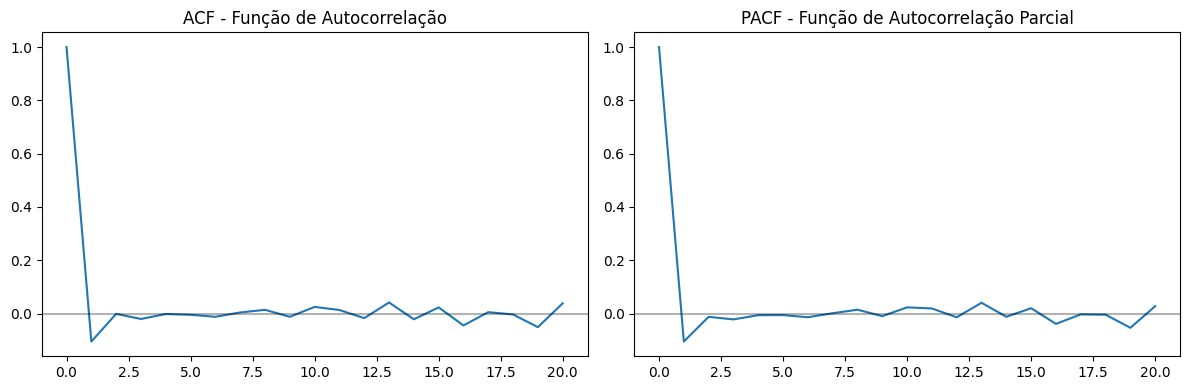

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

lag_acf = acf(ts_diff, nlags=20)
lag_pacf = pacf(ts_diff, nlags=20)

axes[0].plot(lag_acf)
axes[0].set_title("ACF - Função de Autocorrelação")
axes[0].axhline(y=0, color="black", linestyle="-", alpha=0.3)

axes[1].plot(lag_pacf)
axes[1].set_title("PACF - Função de Autocorrelação Parcial")
axes[1].axhline(y=0, color="black", linestyle="-", alpha=0.3)

plt.tight_layout()
plt.show()

### Treinando modelo

In [8]:
best_params = encontra_melhor_param(ts)

Melhores parâmetros: ARIMA(0, 1, 1) com AIC = -18729.41


In [9]:
model = ARIMA(ts, order=best_params)
fitted_model = model.fit()

print(f"Modelo ARIMA ({best_params}) treinado com sucesso!")
print("\nResumo do modelo:")
print(fitted_model.summary())

Modelo ARIMA ((0, 1, 1)) treinado com sucesso!

Resumo do modelo:
                               SARIMAX Results                                
Dep. Variable:                  BRL=X   No. Observations:                 5235
Model:                 ARIMA(0, 1, 1)   Log Likelihood                9366.704
Date:                Mon, 15 Sep 2025   AIC                         -18729.408
Time:                        13:51:12   BIC                         -18716.283
Sample:                             0   HQIC                        -18724.819
                               - 5235                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1061      0.007    -14.289      0.000      -0.121      -0.092
sigma2         0.0016   7.59e-06    215.115      0.000       0.00

### Fazendo previsões

In [10]:
mc_results = gerar_multiplo_forecast(fitted_model, steps=steps, n_simulations=100)

### Visualizando os resultados

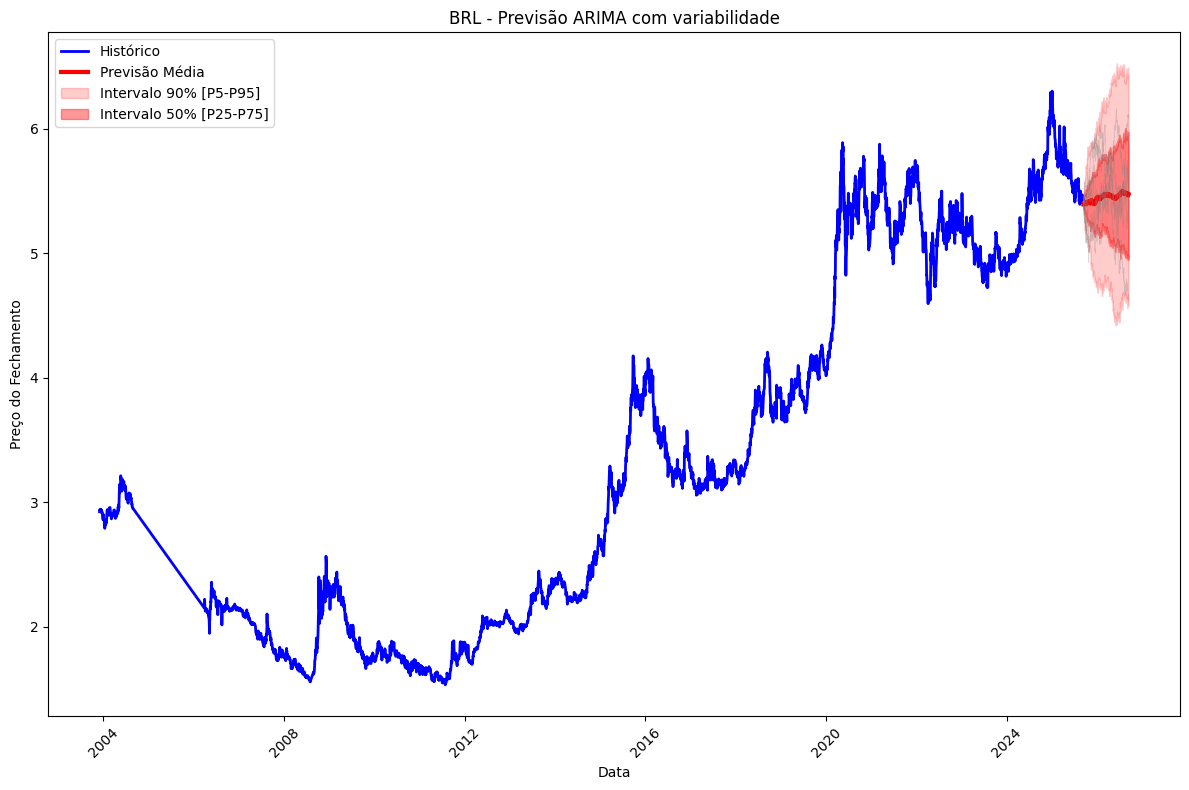

In [11]:
plt.figure(figsize=(12, 8))

# Dados históricos (últimos 60 dias)
# historical = ts[:-60]
historical = ts
plt.plot(historical.index, historical.values.tolist(), label="Histórico", color="blue", linewidth=2)

# Criar datas futuras para as previsões
last_date = ts.index[-1]
# if isinstance(last_date, tuple):
# 	last_date = last_date[0]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=steps, freq="D")

# Plot
plt.plot(future_dates, mc_results["mean"], label="Previsão Média", color="red", linewidth=3)

# Intervalos de confiança 95
plt.fill_between(future_dates, mc_results['p5'], mc_results['p95'],
				 color="red", alpha=0.2, label="Intervalo 90% [P5-P95]")

# Intervalos de confiança 75
plt.fill_between(future_dates, mc_results['p25'], mc_results['p75'],
				 color="red", alpha=0.4, label="Intervalo 50% [P25-P75]")

for i in range(0, 100, 20):
    plt.plot(future_dates, mc_results["all_paths"][i],
             color="gray", alpha=0.3, linewidth=0.5
             )

plt.title("BRL - Previsão ARIMA com variabilidade")
plt.xlabel("Data")
plt.ylabel("Preço do Fechamento")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
# Simular retornos baseados nas previsões
preco_atual = ts.iloc[-1]  # Último preço histórico
retornos_simulados = []

for path in mc_results["all_paths"]:
    retorno_total = (path[-1] - preco_atual) / preco_atual
    retornos_simulados.append(retorno_total)

retornos_simulados = np.array(retornos_simulados)

# Métricas de risco
var_5 = np.percentile(retornos_simulados, 5)  # Value at Risk 5%
var_1 = np.percentile(retornos_simulados, 1)  # Value at Risk 1%
retorno_esperado = np.mean(retornos_simulados)

print(f"\nMétricas de Risco ({steps} dias):")
print(f"Retorno Esperado: {retorno_esperado:.2%}")
print(f"VaR 5%: {var_5:.2%} (95% chance de não perder mais que isso)")
print(f"VaR 1%: {var_1:.2%} (99% chance de não perder mais que isso)")


Métricas de Risco (365 dias):
Retorno Esperado: 1.56%
VaR 5%: -14.46% (95% chance de não perder mais que isso)
VaR 1%: -22.08% (99% chance de não perder mais que isso)


### Salvando o modelo

In [13]:
os.makedirs('./Models/Arima', exist_ok=True)

In [ ]:
with open('../Models/Arima/arima_model_v1.pkl', 'wb') as f:
    pickle.dump(fitted_model, f)

model_info = {
    'best_params': best_params,
    'last_date': ts.index[-1],
    'last_price': ts.iloc[-1],
    'model_summary': str(fitted_model.summary())
}

with open('../Models/Arima/arima_info_v1.pkl', 'wb') as f:
    pickle.dump(model_info, f)

print("Modelo e status salvos com sucesso!")

Modelo e status salvos com sucesso!


### Carregando modelo

In [ ]:
def load_arima_model():
    with open('../Models/Arima/arima_model_v1.pkl', 'rb') as f:
        loaded_model = pickle.load(f)

    with open('../Models/Arima/arima_info_v1.pkl', 'rb') as f:
        model_info = pickle.load(f)

    print(f"Modelo carregado: ARIMA{model_info['best_params']}")
    ultimo_preco = model_info['last_price']
    if hasattr(ultimo_preco, "item"):
        ultimo_preco = ultimo_preco.item()
    print(f"Último preço: {ultimo_preco:.4f}")
    print(f"Última data: {model_info['last_date']}")
    
    return loaded_model, model_info

loaded_model, info = load_arima_model()
new_forecast = gerar_multiplo_forecast(loaded_model, steps=30, n_simulations=100)

Modelo carregado: ARIMA(0, 1, 1)
Último preço: 5.3882
Última data: 2025-09-12 00:00:00
